# 📈 <span style="color:#086591; text-decoration: underline;">Partie Modélisation</span>


Maintenant nous sommes arrivés à la partie de modélisation.
Nous cherchons à expliquer les retards grâce à des variables explicatives. Dans un premier temps, nous allons modéliser le jeu de données existant en adoptant la régression logistique suivie dela méthode Random Forest . Puis, nous nous intéresserons à la comparaison des performances entre ces deux méthodes.

#### Le choix de méthode ###
Nous avons choisi la régression logistique et Random forest car nous sommes en face d'une classification binaire où la variable réponse "Retard" est binaire 

### 🧠 **Régression Logistique :**

un problème de classification binaire de manière linéaire, c’est-à-dire modéliser y £ {0,1}  à l’aide d’une combinaison linéaire de variables.


In [67]:
#bibliothèques
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, chi2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [68]:
data = pd.read_csv("data.csv")
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50697 entries, 0 to 50696
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      50697 non-null  object 
 1   Destination Airport                       50697 non-null  object 
 2   Scheduled departure time                  50697 non-null  object 
 3   Actual departure time                     50697 non-null  object 
 4   Wheels-off time                           50697 non-null  object 
 5   Taxi-Out time (Minutes)                   50697 non-null  float64
 6   Delay Carrier (Minutes)                   50697 non-null  float64
 7   Delay Weather (Minutes)                   50697 non-null  float64
 8   Delay National Aviation System (Minutes)  50697 non-null  float64
 9   Delay Security (Minutes)                  50697 non-null  float64
 10  Delay Late Aircraft Arrival (Minut

In [69]:
df = data.drop('time', axis=1)
colu= ["Season","Period_Day","Weekday_Flight","Destination Airport","Date","Scheduled departure time","Actual departure time","Wheels-off time"]
df = df.drop(columns=colu)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50697 entries, 0 to 50696
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Taxi-Out time (Minutes)                   50697 non-null  float64
 1   Delay Carrier (Minutes)                   50697 non-null  float64
 2   Delay Weather (Minutes)                   50697 non-null  float64
 3   Delay National Aviation System (Minutes)  50697 non-null  float64
 4   Delay Security (Minutes)                  50697 non-null  float64
 5   Delay Late Aircraft Arrival (Minutes)     50697 non-null  float64
 6   Retard                                    50697 non-null  int64  
 7   Weekday_Flight_encoded                    50697 non-null  int64  
 8   Season_encoded                            50697 non-null  int64  
 9   Period_Day_encoded                        50697 non-null  int64  
 10  Destination_encoded               

In [70]:

# Normalisation des colonnes numériques
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Division aléatoire en ensembles d'apprentissage et de test
seed = 131
train_set, test_set = train_test_split(df, test_size=0.2, random_state=seed)



In [71]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40557 entries, 49843 to 30579
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Taxi-Out time (Minutes)                   40557 non-null  float64
 1   Delay Carrier (Minutes)                   40557 non-null  float64
 2   Delay Weather (Minutes)                   40557 non-null  float64
 3   Delay National Aviation System (Minutes)  40557 non-null  float64
 4   Delay Security (Minutes)                  40557 non-null  float64
 5   Delay Late Aircraft Arrival (Minutes)     40557 non-null  float64
 6   Retard                                    40557 non-null  float64
 7   Weekday_Flight_encoded                    40557 non-null  float64
 8   Season_encoded                            40557 non-null  float64
 9   Period_Day_encoded                        40557 non-null  float64
 10  Destination_encoded                

In [72]:

# Sous-échantillonnage
rus = RandomUnderSampler(random_state=seed)
train_undersampled, train_undersampled_labels = rus.fit_resample(train_set.drop('Retard', axis=1),
                                                                 train_set['Retard'])
print(type(train_undersampled))
print(train_undersampled.describe())

# Sur-échantillonnage
ros = RandomOverSampler(random_state=seed)
train_oversampled, train_oversampled_labels = ros.fit_resample(train_set.drop('Retard', axis=1),
                                                               train_set['Retard'])


<class 'pandas.core.frame.DataFrame'>
       Taxi-Out time (Minutes)  Delay Carrier (Minutes)  \
count             25844.000000             25844.000000   
mean                  0.137334                 0.004738   
std                   0.072377                 0.025319   
min                   0.000000                 0.000000   
25%                   0.096045                 0.000000   
50%                   0.118644                 0.000000   
75%                   0.152542                 0.000000   
max                   0.926554                 1.000000   

       Delay Weather (Minutes)  Delay National Aviation System (Minutes)  \
count             25844.000000                              25844.000000   
mean                  0.000852                                  0.003953   
std                   0.012844                                  0.015173   
min                   0.000000                                  0.000000   
25%                   0.000000                    

In [73]:
# Modèle de régression logistique
x_train = train_oversampled
y_train = train_oversampled_labels
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Coefficients du modèle
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
coeff_df = pd.DataFrame({'Variable': x_train.columns, 'Coefficient': coefficients})
coeff_df.loc[len(coeff_df)] = ['Intercept', intercept]
print(coeff_df)

# Calcul des statistiques
n = len(y_train)
p = x_train.shape[1]
X = np.hstack((np.ones((n, 1)), x_train))
y_pred = clf.predict(x_train)
residus = y_train - y_pred
sigma_hat = np.sqrt(np.sum(residus ** 2) / (n - p))
var_cov_beta = np.linalg.inv(X.T @ X) * sigma_hat ** 2
std_err_beta = np.sqrt(np.diag(var_cov_beta))

# Variables significatives
alpha = 0.1
z_score = clf.coef_ / std_err_beta[1:]
p_values = 2 * (1 - chi2.cdf(z_score ** 2, 1))
significant_vars = x_train.columns[np.array(p_values).reshape(-1) < alpha]
print("Variables significatives :", significant_vars)

# Modèle réduit aux variables significatives
significant_coefs = clf.coef_[0][np.isin(x_train.columns, significant_vars)]
significant_model = pd.DataFrame({'Variable': significant_vars, 'Coefficient': significant_coefs})
print("Modèle significatif :\n", significant_model)

# Corrélation de Pearson
pearson_correlation = []
pearson_p_value = []
for var in x_train.columns:
    correlation, p_value = pearsonr(x_train[var], y_train)
    pearson_correlation.append(correlation)
    pearson_p_value.append(p_value)

alpha = 0.05
significant_vars = [var for var, p_value in zip(x_train.columns, pearson_p_value) if p_value < alpha]
print("Variables significatives (avec une erreur alpha de 5%) : \n", significant_vars)


                                    Variable  Coefficient
0                    Taxi-Out time (Minutes)     2.765947
1                    Delay Carrier (Minutes)    25.028333
2                    Delay Weather (Minutes)     5.823790
3   Delay National Aviation System (Minutes)    10.544062
4                   Delay Security (Minutes)     3.915299
5      Delay Late Aircraft Arrival (Minutes)    24.065809
6                     Weekday_Flight_encoded    -0.107880
7                             Season_encoded    -0.206194
8                         Period_Day_encoded    -0.090898
9                        Destination_encoded    -0.278803
10                       temperature_2m (°C)     0.522650
11                  relative_humidity_2m (%)    -0.663656
12                        precipitation (mm)    -0.419743
13                            snow_depth (m)     0.205710
14                   weather_code (wmo code)     0.329572
15                    surface_pressure (hPa)     0.287332
16            

In [74]:
def model_evaluation(model, seuil):
    predictions = model.predict_proba(test_set.drop('Retard', axis=1))[:, 1]
    predicted_status = (predictions > seuil).astype(int)
    
    conf_mat = pd.crosstab(test_set['Retard'], predicted_status, dropna=False)
    conf_mat = conf_mat.reindex(index=[0, 1], columns=[0, 1], fill_value=0)

    # Vérifiez si la matrice est correcte
    if conf_mat.shape[0] < 2 or conf_mat.shape[1] < 2:
        raise ValueError("Matrice de confusion incomplète ou incorrecte.")

    TP = conf_mat.iloc[1, 1]
    TN = conf_mat.iloc[0, 0]
    FP = conf_mat.iloc[0, 1]
    FN = conf_mat.iloc[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return {
        'Classification Score': accuracy,
        'Model Sensitivity': sensitivity,
        'Model Specificity': specificity
    }
    
 
# Résultats du modèle
results = model_evaluation(clf, 0.3)
print(results)   


{'Classification Score': 0.3214990138067061, 'Model Sensitivity': 0.9977876106194691, 'Model Specificity': 0.014764908256880734}


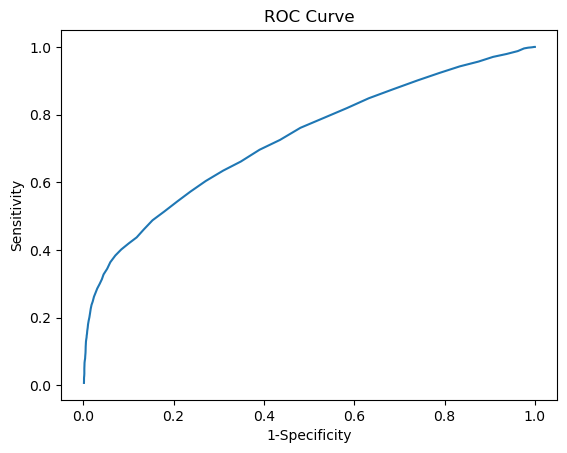

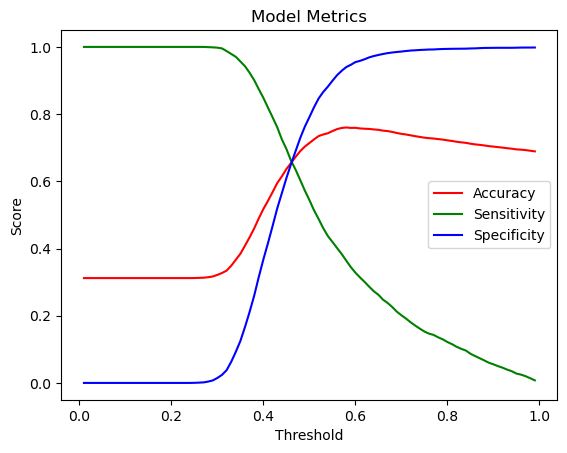

In [75]:
# Courbes ROC et métriques
def print_results(model):
    seuils = np.arange(0.01, 1.0, 0.01)
    acc_model, sens_model, spec_model, one_minus_spec_model = [], [], [], []
    for i in seuils:
        r = model_evaluation(model, i)
        acc_model.append(r['Classification Score'])
        sens_model.append(r['Model Sensitivity'])
        spec_model.append(r['Model Specificity'])
        one_minus_spec_model.append(1 - r['Model Specificity'])
    result_df = pd.DataFrame({
        'Thresholds': seuils,
        'Accuracy': acc_model,
        'Sensitivity': sens_model,
        'Specificity': spec_model,
        '1-Specificity': one_minus_spec_model
    })
    
    # Courbe ROC
    plt.figure()
    plt.plot(result_df['1-Specificity'], result_df['Sensitivity'])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.show()

    # Courbes des métriques
    plt.figure()
    plt.plot(result_df['Thresholds'], result_df['Accuracy'], label='Accuracy', color='red')
    plt.plot(result_df['Thresholds'], result_df['Sensitivity'], label='Sensitivity', color='green')
    plt.plot(result_df['Thresholds'], result_df['Specificity'], label='Specificity', color='blue')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Model Metrics')
    plt.show()

print_results(clf)


### 🧠 **Random Forest :**


In [76]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Retard'])
y = df['Retard']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Accuracy: 0.8046679815910586
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.97      0.87     10298
         1.0       0.87      0.47      0.61      4912

    accuracy                           0.80     15210
   macro avg       0.83      0.72      0.74     15210
weighted avg       0.82      0.80      0.79     15210



Text(50.722222222222214, 0.5, 'Actual')

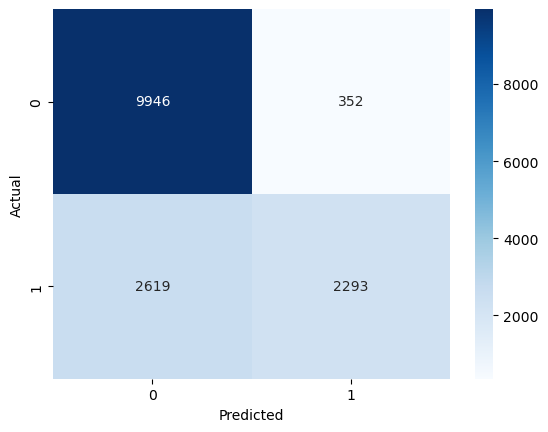

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [78]:
feature_importances = rf.feature_importances_
features = df.drop(columns=['Retard']).columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)


                                     Feature  Importance
1                    Delay Carrier (Minutes)    0.186276
0                    Taxi-Out time (Minutes)    0.080715
5      Delay Late Aircraft Arrival (Minutes)    0.079333
15                    surface_pressure (hPa)    0.067222
10                       temperature_2m (°C)    0.067038
19                     wind_speed_10m (km/h)    0.065998
20                    wind_direction_10m (°)    0.065096
9                        Destination_encoded    0.059677
18             vapour_pressure_deficit (kPa)    0.059156
11                  relative_humidity_2m (%)    0.054145
3   Delay National Aviation System (Minutes)    0.039161
16                           cloud_cover (%)    0.034265
6                     Weekday_Flight_encoded    0.030214
17                       cloud_cover_low (%)    0.028265
14                   weather_code (wmo code)    0.016616
7                             Season_encoded    0.016269
8                         Perio

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s


KeyboardInterrupt: 